#  Tumors in Rats

##### Keywords: rat tumors, MCMC, gibbs sampler, hierarchical, prior, noninformative prior, bayesian updating,  bayesian, posterior, posterior predictive, beta, binomial, beta-binomial

In [1]:
%matplotlib inline
import numpy as np
from scipy import stats
from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import distributions
import matplotlib.pyplot as plt
import seaborn as sns
import time
sns.set_style('white')
sns.set_context('paper')

## Summary

A full bayesian treatment of the rat tumor hierarchical model, including a discussion on the choice of hyperprior, and posterior predictions for both an existing $\theta_i$ and for a new $\theta_{71}$.

---

## Contents
{:.no_toc}
* 
{: toc}

This is an implementation of a [hierarchical]({{ links.hierarch }}) model from [Gelman](http://www.stat.columbia.edu/~gelman/book/), chapter 5. Gelman uses simulation there, but here we carry out full posteror simulations using MCMC.

The below data is from tumors in female rats of type "F344" that recieve a particular drug, in 70 different experiments. 

The first column is the number that get the tumor; the second is the total number or rats tested

## Data

In [2]:
tumordata="""0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 20 
0 19 
0 19 
0 19 
0 19 
0 18 
0 18 
0 17 
1 20 
1 20 
1 20 
1 20 
1 19 
1 19 
1 18 
1 18 
3 27 
2 25 
2 24 
2 23 
2 20 
2 20 
2 20 
2 20 
2 20 
2 20 
1 10 
5 49 
2 19 
5 46 
2 17 
7 49 
7 47 
3 20 
3 20 
2 13 
9 48 
10 50 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
4 20 
10 48 
4 19 
4 19 
4 19 
5 22 
11 46 
12 49 
5 20 
5 20 
6 23 
5 19 
6 22 
6 20 
6 20 
6 20 
16 52 
15 46 
15 47 
9 24 
"""
tumortuples=[e.strip().split() for e in tumordata.split("\n")]
tumory=np.array([np.int(e[0].strip()) for e in tumortuples if len(e) > 0])
tumorn=np.array([np.int(e[1].strip()) for e in tumortuples if len(e) > 0])


## Model
As in the original notebook, we suppose that each trial has an individualized true cancer rate $\theta_i$. Given that true rate, the actual number of rats with tumors should follow a binomial, using the number of rats in that trail and the specific tumor rate in that trial. We assume the $theta_i$ all come from a beta distribution, since that's the conjugate prior for a binomial. We don't write down fixed parmeters $\alpha$ and $\beta$ for that beta distribution, but let them float instead. We choose an uninformative (jeffery's) prior for these hyperparameters.

$$ 
  \alpha,\beta \propto (\alpha+\beta)^\frac{5}{2}\\
  \theta_i \sim Beta(\alpha, \beta)\\
  y_i \sim Binom(n_i,\theta_i)\\
$$

The graphically, the model looks like this:

![](images/hier.png)

In the prior notebook, we took a shortcut via Empericla Bayes, and then survived the tougher math for the fully bayesian alaysis. We found the following (conditional, not joint) posteriors:

$$p(\alpha | Y=\{y\}, \Theta=\theta, B=\beta) \propto p(\alpha, \beta) \, \left(\frac{\Gamma(\alpha + \beta)}{\Gamma(\alpha)}\right)^N \prod_{i=1}^{N} \theta_i^{\alpha}$$

$$p(\beta | Y=\{y\}, \Theta=\theta, A=\alpha ) \propto p(\alpha, \beta) \, \left(\frac{\Gamma(\alpha + \beta)}{\Gamma(\beta)}\right)^N \prod_{i=1}^{N} (1 - \theta_i)^{\beta}$$

$$p(\theta_i|Y=\{y_i\}, A=\alpha,B=\beta) = Beta(\alpha + y_i, \beta + n_i - y_i)$$

**In this notebook, we implement the code to sample from this model.**. I.e., from its joint posterior. We'll use Gibbs since we have conditional distributions and want samples from their joint distribution.

## Sampling 

We construct a combined Gibbs sampler using the above conditionals: the draws for the $\theta_i$ is simple because of conjugacy. But for $\alpha$ and $\beta$, we implement a Metropolis-Hastings sampler, use a normal proposal with mean the current values of $\alpha$ and $\beta$  and standard deviations 0.25 and 3 respectively.

Let's get started.

#### Sidebar: Using logs

So far we have used raw distributions directly for our sampling.  This is a bad idea for large numbers of parameters (here we have 72) or large datasets: the value of the distribution at any particular place is going to be tiny. Small numbers multiply smaller and we can get underflow fast. 

We always want to work in terms of the log probability instead of the raw probability. It's far more precise to subtract -72 from -56 than to do $\frac{10^{-56}}{10^{-72}}$.

We set up python functions for each draw

In [3]:
from scipy.special import gammaln

numthetas=tumorn.shape[0]

# prior for the hyperparameters
def log_prior(a, b):
    if a <= 0 or b <=0:
        return -np.inf
    return -2.5*np.log(a + b)

# sampling from conditional posterior for the theta
draw_thetas = lambda a,b: beta.rvs(a+tumory,b+tumorn-tumory, size=numthetas)

# conditional posterior (pdf) for alpha
def log_cond_alpha(a,b, thetas):
    if a <= 0 or b <=0:
        return -np.inf
    return numthetas*(gammaln(a+b) - gammaln(a)) + a*np.sum(np.log(thetas)) + log_prior(a,b)
   
# conditional posterior (pdf) for beta
def log_cond_beta(a,b, thetas):
    if a <= 0 or b <=0:
        return -np.inf
    return numthetas*(gammaln(a+b) - gammaln(b)) + b*np.sum(np.log(1.0 - thetas)) + log_prior(a,b)
  
# using the above pdfs we draw for alpha and beta in MH fashion
def draw_alpha(a,b,thetas,proposal_sd, accepts):
    astar = norm.rvs(a,proposal_sd)  # proposed a new alpha
    num = log_cond_alpha(astar,b, thetas) 
    den = log_cond_alpha(a,b, thetas)
    R=np.random.rand()
    if (np.log(R) <= num - den): 
        accepted=1
    else:
        accepted=0
    accepts['alpha'] = accepts['alpha'] + accepted
    if accepted:
        return astar
    else:
        return a

def draw_beta(a,b,thetas,proposal_sd, accepts):
    bstar = norm.rvs(b,proposal_sd)
    num = log_cond_beta(a,bstar, thetas)
    den = log_cond_beta(a,b, thetas)
    R=np.random.rand()
    if (np.log(R) <= num - den):
        accepted=1
    else:
        accepted=0
    accepts['beta'] = accepts['beta'] + accepted
    if accepted:
        return bstar
    else:
        return b

We initialize variables for our sampler.

In [4]:
burnin=20000
numtraces=200000
totaltraces=burnin+numtraces

alphas=np.empty(totaltraces)
betas=np.empty(totaltraces)
thetas=np.empty((totaltraces, numthetas))

# these are the step sizes for the proposal distribution
# for our M-H sampling for alpha and beta to be used in Gibbs sampling later
alpha_prop_sd=0.6
beta_prop_sd=3.2

#start positions
alphas[0]=1.
betas[0]=1.
thetas[0,:] = (tumory+0.5)/(tumorn+0.5)

#draw_thetas(alphas[0], betas[0])
accepteds={'alpha':0, 'beta':0}

This is the main loop of our sampler. Notice the structure: for alpha we take from the previous step, for beta we take the changed alpha from the current step, and for the thetas we take both alpha and beta from the current step.

In [5]:
start = time.clock()

for m in np.arange(1,totaltraces):
    alphas[m] = draw_alpha(alphas[m-1],betas[m-1],thetas[m-1,:], alpha_prop_sd, accepteds)
    betas[m] = draw_beta(alphas[m],betas[m-1],thetas[m-1,:], beta_prop_sd, accepteds)
    thetas[m,:] = draw_thetas(alphas[m],betas[m])

print("sampling took: ", time.clock()-start, " seconds.")

sampling took:  110.15821653333333  seconds.


Check our acceptance ratio, and then remove burnin samples and thin

In [6]:
accepteds['alpha']/numtraces, accepteds['beta']/numtraces

(0.364135, 0.432585)

In [7]:
#remove burnin samples and thin
thin=40
alphatrace=alphas[burnin+1:totaltraces:thin]
betatrace=betas[burnin+1:totaltraces:thin]
thetastrace=thetas[burnin+1:totaltraces:thin,:]
print(thetastrace.shape, alphatrace.shape)

(5000, 70) (5000,)


#### Traces and autocorrelation
We check our traces.

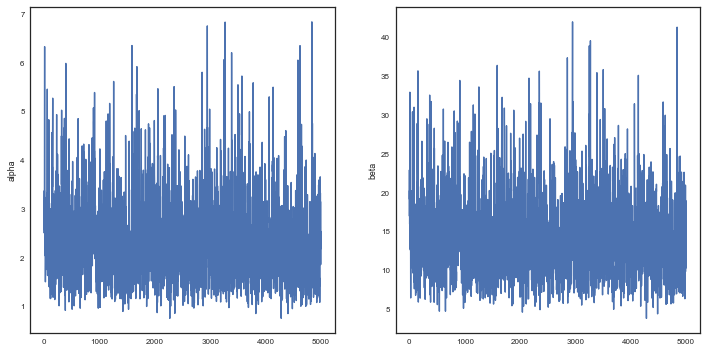

In [8]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
plt.plot(alphatrace)
plt.ylabel('alpha')
plt.subplot(1,2,2)
plt.plot(betatrace)
plt.ylabel('beta');

In [9]:
def corrplot(trace, maxlags=50):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])

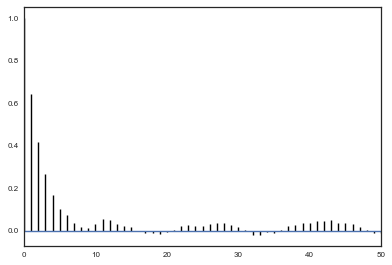

In [10]:
corrplot(alphatrace)

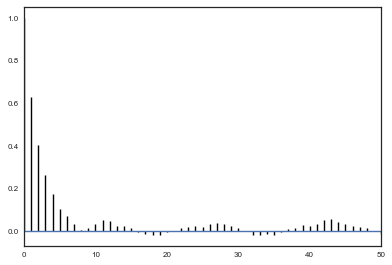

In [11]:
corrplot(betatrace)

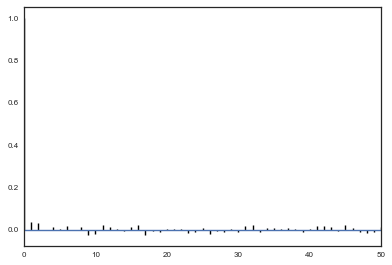

In [12]:
corrplot(thetastrace[:,7])

The $\alpha$ and $\beta$ may have more correlation than we'd like, but correlated at a lag of 10 isn't too bad in the overall scheme. We can combat that with a longer runtime and more thinning, or by mucking with the model specification. We'll do neither, and press on.

It looks like the Gibbs process reach its stationary target (though we'd prefre to restart it from multiple origins to be sure). Assuming it did reach stationarity, we've got our samples from the posterior, and it's time to analyze.

## The posterior 

We plot the $\alpha$ and $\beta$ marginals and create a 2D histogram or KDE plot (`sns.kdeplot` in seaborn) of the marginal posterior density in the space $x = \alpha/\beta$, $y = log(\alpha + \beta)$. We also look at the marginal of $\theta_1$.

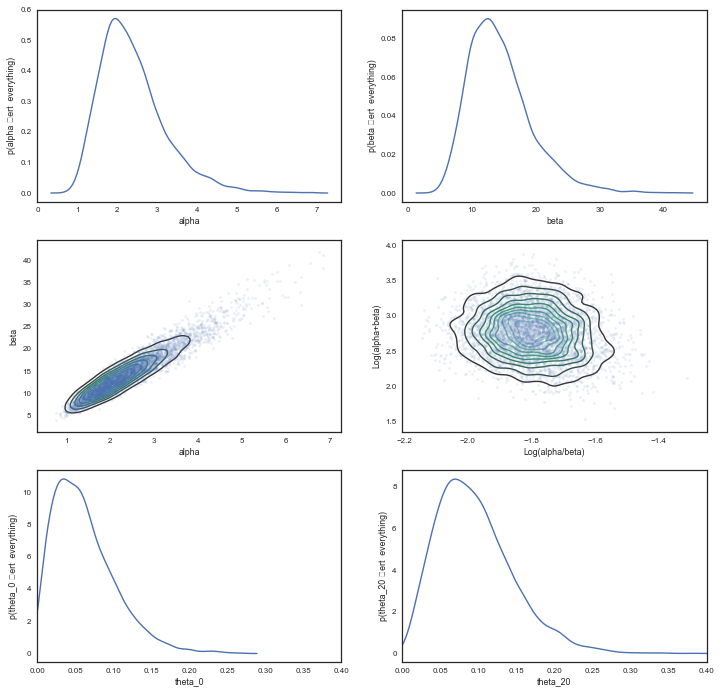

In [24]:
plt.figure(figsize=[12,12])
plt.subplot(3,2,1)

sns.kdeplot(alphatrace)
plt.xlabel('alpha')
plt.ylabel('p(alpha \vert  everything)')
plt.subplot(3,2,2)
sns.kdeplot(betatrace)
plt.xlabel('beta')
plt.ylabel('p(beta \vert  everything)')
plt.subplot(3,2,3)
plt.plot(alphatrace, betatrace,'.', alpha=0.1)
sns.kdeplot(alphatrace, betatrace)
plt.xlabel('alpha')
plt.ylabel('beta')

plt.subplot(3,2,4)
plt.plot(np.log(alphatrace/betatrace), np.log(alphatrace+betatrace),'.', alpha=0.1)
sns.kdeplot(np.log(alphatrace/betatrace), np.log(alphatrace+betatrace))
plt.xlabel('Log(alpha/beta)')
plt.ylabel('Log(alpha+beta)')

plt.subplot(3,2,5)
sns.kdeplot(thetastrace[:,0])
plt.xlabel('theta_0')
plt.ylabel('p(theta_0 \vert  everything)');
plt.xlim(0,.4)

plt.subplot(3,2,6)
sns.kdeplot(thetastrace[:,20])
plt.xlabel('theta_20')
plt.ylabel('p(theta_20 \vert  everything)');
plt.xlim(0,.4);

Above we see that $\alpha$ and $\beta$ have closed in to a fairly tight range. Further, we can examine the posteriors for any one of the $\theta_i$. In this example, we see that trial 0 has posible true cancer rates peaking at 0.05 while trial 20 peaks around 0.07.

### Visualizing posterior for all the $\theta_i$ 

We plot the observed tumor rates on the x-axis against posterior medians for each of the 70 $\theta$'s on the y axis, along with error bars obtained from finding the 2.5 and 97.5 percentiles. 

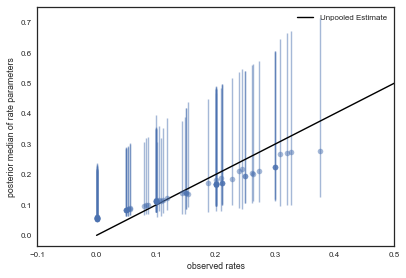

In [14]:
percentiles=np.percentile(thetastrace, [2.5,50.0, 97.5], axis=0)
lowerthetas, medianthetas, upperthetas=percentiles

empirical_ratios=tumory/tumorn

plt.errorbar(empirical_ratios, 
             medianthetas, yerr=[lowerthetas,upperthetas], fmt='o', alpha=0.5)
plt.plot([0,0.5],[0,0.5],'k-', label="Unpooled Estimate")
plt.xlabel("observed rates")
plt.ylabel("posterior median of rate parameters")

plt.xlim(-0.1,0.5)
plt.legend();

There you have it: each $\theta$ has its own distribution of possibilites, but the trials with low observed rates (e.g. zero tumors) are estimated as being too low (the distribution of possible theta stretches from about 0.005 up to larger values). Trials with high rates are likewise given higher-than-average thetas, but not as high as the trial itself suggests; there's data in other trials suggesting the rate is lower overall.

In total: our model makes the $\theta_i$ interdependent. We get to borrow knowledge from other trials in working out the distribution of possible values for a particular $\theta_i$.

## The predictives

In a hierarchical model, there are two kinds of posterior predictions that are useful. (1) The distribution of future observations $\tilde{y}$ given a $\theta_i$, and (2) The distribution of observations $\tilde{y}$ drawn from a future $\theta_j$ drawn from the super-population (i.e. using the Beta on the estimated hyper parameters).

The first kind of posterior predictive is easy to get, since we have traces of all the $\theta$s:

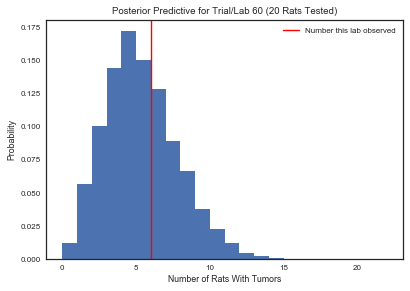

In [30]:
from scipy.stats import binom
pred60 = binom.rvs(tumorn[60],thetastrace[:,60])
plt.hist(pred60, bins=np.arange(tumorn[60]), normed=True);
plt.axvline(tumory[60],0,1,color='r', label="Number this lab observed");

plt.title("Posterior Predictive for Trial/Lab 60 (20 Rats Tested)")
plt.xlabel("Number of Rats With Tumors")
plt.ylabel("Probability")
plt.legend();

So we see that we should think that this lab had a slightly rare event. If it we're to re-do the experiment we'd bet on some regression to the mean and a lower number of rats with tumors.

For the second kind of posterior (across all posible $\theta$, rather than a fixed $\theta_i$ value), we would simply grab an $\alpha$,$\beta$ pair from the trace, grab a $\theta$ from the beta distribution with those parameters, and a $y$ from the binomial with $\theta$ and n as parameters. We'd repeat this process a few thousand times and plot the resulting $y$s

As a shortcut, we could skip getting $\alpha$,$\beta$ and just grab a $\theta$ value from the trace for $\theta$, as these values are intended to be samples from the marginal for $\theta$ anyway.

### Extension: The 71st experiment
Suppose there is one more lab: it had 4 tumors in 10 rats. What's our posterior for this lab? [Properly, We'd need to fold this lab's tumors and rats into the overall dataset, since it will slightly change the posteriors for everything, and then we just predict it like above. We'll ultimately cheat and ballpark it as having exactly the posteriors we had without seeing 10 more rats and 4 more tumors]

We wish to understand what happens for the 'future' $\theta_{71}$.
and then, finally, compute the posterior prediction for the 71st experiment. A key point is that $\theta_{71}$ could be anything from the distribution of all $\theta$s.

Remember the conditional structure of our problem. $\theta_{71}$'s parents in the graph are $\alpha$ and $\beta$ so it suffices to sample from them (marginalize over them) to get the $\theta_{71}$ posterior.

$$p(\theta_{71}, \theta_{1..70}, \alpha, \beta \vert  D)  \propto p(y_{71} \vert n_{71}, \theta_{71} ) p(\theta_{71} \vert \alpha, \beta) p(\theta_{1..70}, \alpha, \beta \vert  D)$$

In other words the full posterior so far (for the 70 experiments) becomes the new prior for experiment 71. We saw this earlier with globe tossing: posteriors become our priors for new results, since the posterior is explicitly meant to capture all available information. 

We need to mix in a prior for $\theta_{71}$ as well, and then the likelihoof for $y_{71}$. Then we simply marginalize over everything to get the $\theta_{71}$ posterior.

$$p(\theta_{71} \vert \theta_{1..70}, \alpha, \beta, D) = \int d\alpha \,d\beta \,d\theta_{1..70} \,p(\theta_{71}, \theta_{1..70}, \alpha, \beta \vert  D)$$

$$ =  \int d\alpha \,d\beta  Beta(\alpha+y_{71}, \beta + n_{71} - y_{71})  \int_{\theta_{1..70}} \,d\theta_{1..70} \,p(\theta_{1..70}, \alpha, \beta \vert  D)$$

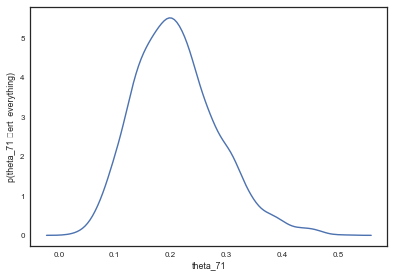

In [17]:
post71 = beta.rvs(alphatrace+4, betatrace+10)
sns.kdeplot(post71)
plt.xlabel('theta_71')
plt.ylabel('p(theta_71 \vert  everything)');

In [18]:
# numpy function falttens by default
percentiles =np.percentile(post71, [2.5,50.0, 97.5])

print("Percentiles: ", percentiles)
print("Naive rate: ", 4.0/14)

Percentiles:  [ 0.08562998  0.20384851  0.37858762]
Naive rate:  0.2857142857142857


And the predictive can be trivially calculated looking at the posterior samples.

### The structure of Bayesian updating

Notice something about the posterior of $\theta_{71}$. Its exact after the 71st experiment, because to obtain it we had to marginalize over everything else. But the formulas for the posteriors for all the other parameters have changed, because we ought to be marginalizing over $\theta_{71}$ for them as well.  Thus the samples for these parameters will no-longer be representative of the true posteriors...they are not borrowing any "statistical juice" fromn the $\theta_{71}$ samples.

What you would have to do is to take the previous steps posterior,  make a kernel density estimate of it, and use that as a prior on  $\alpha, \beta, \theta_{1..70}$. Multiply in the prior of $\theta_{71}$ and you have the full prior, now write the full likelihood and  thus obtain the full posterior. We do, however, lose our conjugacy and sampling is less fun (and all MH).

### Extra: Finding the uninformative prior

The hyperparameters $\alpha$ and $\beta$ are hard to interpret for the putpose of setting up a hyper-prior distribution.

So let us consider instead, 
the 'prior' mean $\mu$ of the beta population distribution for $\{\theta_i\}$ is given by $\frac{\alpha}{\alpha + \beta}$, and the variance is given by $\frac{\mu (1-\mu)}{\alpha +\beta +1}$. 

We'll use non-informative priors here, although you could use a weakly informative prior such as $Cauchy(0,1)$ on the standrd deviation.

But notice the following approximation:

$$\sigma \approx \sqrt{\frac{\mu(1-\mu)}{\alpha+\beta}} $$

(looks like the sampling error on a binomial wth prior numbers put in! Not surprising as this is a Beta.)

Now, $p(\mu, \sigma) = p(\sigma \vert \mu)p(\mu)$, and notice that for constant $\mu$ the $\sigma$ dependence is on $1/\sqrt{\alpha + \beta}$. Thus we transform to variables $\mu$ and $s =  1/\sqrt{\alpha + \beta}$.

Now $dP(\alpha, \beta) = dP(\mu, s)$, and so:

$$\pi(\alpha, \beta) d\alpha d\beta =  p(s(\alpha, \beta) \vert \mu(\alpha, \beta)) p(\mu(\alpha, \beta))\mid\frac{\partial(\mu(\alpha, \beta), s(\alpha, \beta))}{\partial(\alpha, \beta)}\mid d\alpha d\beta$$

We thus choose to set up a uniform prior on 

$$\left(\frac{\alpha}{\alpha + \beta}, (\alpha + \beta)^{-1/2}\right),$$

where we have used

$$ d\mu ds = J d\alpha d\beta$$

and written the jacobian in this strange partial derivative notation.

Now, non-informative priors means that  $p(\sigma \vert \mu)$ and $p(\mu)$ are both $\propto 1$, and the Jacobian is proportional to  $(\alpha + \beta)^{-5/2}$

Thus we are yielded a hyperprior $p(\alpha, \beta) \sim (\alpha + \beta)^{-5/2}$.  

This is not the only scheme via which an uninformative (or for that matter, weakly informative) hyperprior distribution which will be dominated by the likelihood can be set, and it is worth exploring other options, such as other powers of $(\alpha + \beta)$.

